In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os

#set working_dir
working_dir = os.path.join(os.getcwd(), 'Major-HW1')

url_base = 'https://github.com/danielantebi/Major-HW1/raw/main/{}.csv'

all_data = url_base.format('virus_data')
train_url = url_base.format('virus_data')
test_url = url_base.format('virus_data')

data = pd.read_csv(all_data, header=0)
train = pd.read_csv(train_url, header=0)
test = pd.read_csv(test_url, header=0)


In [3]:
def visualize_clf(clf, X, Y, title,
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)

    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()


**Part 1: Data Loading and First Look**

The VTC dataset, available on the course website as virus_data.csv, should be loaded and explored using the pandas library. It contains features relevant to our prediction tasks, along with ground-truth labels for our target variables: spread (potential to spread COVID-19) and risk (risk of serious illness). All your decisions in the data preparation process should be made with these targets in mind.

Unfortunately, as with any real-world dataset, VTC includes many redundancies and noise. Throughout this exercise, we will work to minimize these issues. Note: The dataset is synthetic and may not match real-world statistics.


(Q1)	Load the dataset into a Pandas DataFrame.
Answer (in your report): how many rows and columns are in the dataset?


In [4]:
r, c = data.shape
print(f'There are {r} rows and {c} columns in the dataset')

There are 1250 rows and 25 columns in the dataset


Before we continue, let us define the “ordinal” variable type. Ordinal variables are categorical with a natural order (e.g., year of birth), and are somewhere between continuous and categorical variables.



(Q2)	Print the value_counts of the conversations_per_day feature (see Tutorial 01).
Copy the obtained output to your report. Describe in one short sentence what you think this feature refers to in the real world.
This feature’s type is “ordinal”. Explain briefly why.
Remember to clearly write the number of the question next to your answer.


In [5]:
data.conversations_per_day.value_counts()

conversations_per_day
3     218
2     204
5     179
4     168
1     108
6     107
7      94
8      54
9      42
10     29
11     16
13      8
12      7
14      6
16      5
15      3
17      1
29      1
Name: count, dtype: int64

:We assume that the feature referas to how many face to face converstation this person does every day

(Q3)	In your report, write a table describing each feature. The columns must be:

a.	Feature name: the name of the feature as it is written in the dataset.

b.	Description: a short sentence with your understanding of the feature’s meaning in the real world.

c.	Type: Continuous, Categorical, Ordinal, or Other.

Don’t overthink this (especially the “ordinal” type), some variable may be suitable for two types.
Note: do not include the target columns (“spread” and “risk”).


In [6]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             1250 non-null   int64  
 1   age                    1250 non-null   int64  
 2   sex                    1250 non-null   object 
 3   weight                 1250 non-null   float64
 4   blood_type             1250 non-null   object 
 5   current_location       1250 non-null   object 
 6   num_of_siblings        1250 non-null   int64  
 7   happiness_score        1250 non-null   int64  
 8   household_income       1141 non-null   float64
 9   conversations_per_day  1250 non-null   int64  
 10  sugar_levels           1250 non-null   int64  
 11  sport_activity         1250 non-null   int64  
 12  pcr_date               1250 non-null   object 
 13  PCR_01                 1250 non-null   float64
 14  PCR_02                 1250 non-null   float64
 15  PCR_

,patient_id,age,sex,weight,blood_type,current_location,num_of_siblings,happiness_score,household_income,conversations_per_day,...,PCR_03,PCR_04,PCR_05,PCR_06,PCR_07,PCR_08,PCR_09,PCR_10,spread,risk
0,733,31,F,80.8,O-,"('11.93381', '79.82979')",6,6,0.7,5,...,-154.375498,176.847024,4.385181,10.213329,0.927466,22.333871,2.392578,-126.780598,1.0,1
1,382,29,F,63.0,O+,"('51.67822', '33.9162')",1,9,NaN,11,...,-200.700948,-7.135415,7.128887,30.027329,-0.084755,1.700489,2.735347,-175.576828,-1.0,-1
2,1164,44,F,74.2,O+,"('60.02427', '30.28491')",2,10,1.5,3,...,127.222441,59.712513,1.227654,16.907687,1.609130,7.258721,4.937827,-233.105192,-1.0,-1
3,897,9,M,31.8,O-,"('51.08468', '7.11393')",3,9,0.5,8,...,116.178667,72.100204,6.181840,17.018475,2.313162,1.707770,1.686465,-28.548362,-1.0,-1
4,1187,18,F,42.4,A-,"('38.45598', '48.87498')",0,8,0.2,4,...,71.377753,187.436001,4.709932,13.888960,5.401181,4.500906,3.767817,-27.173870,-1.0,-1


**Can't add table in colab, created the table already in goole docs**




Partitioning the data
During the learning process, we measure our models’ performance on two disjoint sets: training and test. A training set is a subset of the dataset from which the machine learning algorithm learns relationships between features and target variables. The test set provides a final estimate of the machine learning model’s performance after it has been trained. Test sets should never be used to make decisions about which algorithms to use or for improving or tuning algorithms.

We will explore why this data partitioning is important later in the course, but for now, the most important thing to remember is that you may only use the training set for making decisions about the data, training our models, plotting graphs regarding our data, and deciding how to normalize features. The training set will help us understand what pre-processing steps we need to use on the data. You should then apply those pre-processing steps to both the training and the test set.
Note: later in the course, we will use another data subset, called the validation set.


(Q4)	Split the data randomly into a training set (80% of the data) and a test set (20% of the data). As the random_state, use the sum of the last two digits of each of your IDs  (two or three IDs).
The random state will ensure that you get the same split every time.
Answer: Why is it important that we use the exact same split for all our analyses?

Note: it could be easier for you to answer this question after you complete the rest of the assignment.


In [7]:
random_state = 72 #sum of our id
np.random.seed(random_state)

shuffle = np.random.permutation(len(data))
train_size = int(0.8 * len(data))
train_idx = shuffle[:train_size]
test_idx = shuffle[train_size:]

train = data.iloc[train_idx]
test = data.iloc[test_idx]

train.to_csv('train.csv', index = False)
test.to_csv('test.csv',index = False)


Using the same data split keeps the results consistent, comparisons fair, and conclusions reliable. It ensures everything is repeatable and valid, which is crucial in data analysis.

**Part 2: Missing Values**

We will start with basic checks of our datasets, focusing on missing values, which are a common issue in machine learning. Missing values refer to data points that are absent in a specific column, often represented as null values. They pose a significant challenge in data analysis and can lead to inaccurate or biased results. Data can be missing due to technical issues, human errors, privacy concerns, and more.


(Q5)	For both the training set and test set, report which fields have missing values and how many missing values there are. You can use Panda's function isnull().

In [8]:
print(f"fields with missing values in training set: {train.columns[train.isnull().any()].tolist()}")
print(f"number of missing values in trainig set: {train.isnull().sum().sum()}")

print(f"fields with missing values in test set: {test.columns[test.isnull().any()].tolist()}")
print(f"number of missing values in test set: {test.isnull().sum().sum()}")

fields with missing values in training set: ['household_income']
number of missing values in trainig set: 83
fields with missing values in test set: ['household_income']
number of missing values in test set: 26


Another term we will use is "Outliers". There are many ways to define outliers; here, we refer to them as data points that significantly deviate from the rest of the data. Note that we won't solve the outliers issue in this section, only the missing values issue.

(Q6)	Plot a histogram (see Tutorial 01) for each field where you found missing values in ‎(Q5). Add these plots to your report. Answer: Can you recognize outliers?
Reminder: Create plots using only the training set.


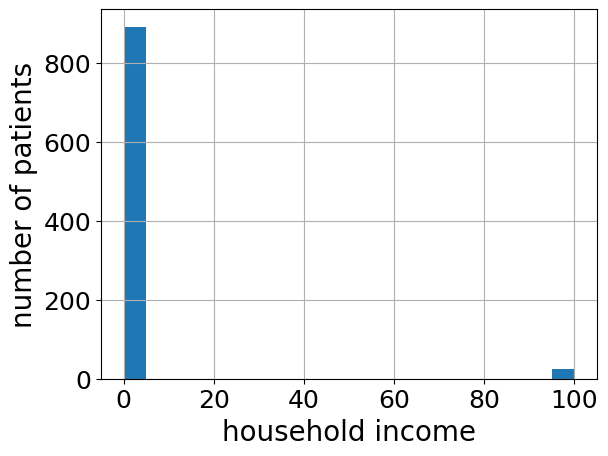

In [9]:
#Given params for matplotlib plots
from matplotlib import pylab
params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize' : 22,
          'axes.labelsize' : 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24 }
pylab.rcParams.update(params)

train.household_income.plot(kind='hist', bins=20)

plt.ylabel("number of patients")
plt.xlabel("household income")
plt.grid()



There are many ways of dealing with missing values. We will consider two of them:

a.	Calculate this field's mean value in the train set and use it to replace the missing values in both the train and test set.

b.	Like (a), but using the median instead of the mean.

(Q7)	For each field where you found missing values, calculate the median and the mean in the training set, and report it.
If there is a significant difference between the mean and median values, explain the reason. Which filling method do you prefer to use in our case, and why?


In [10]:
print(f"median household income: {train.household_income.median()}")
print(f"mean household income: {train.household_income.mean()}")

median household income: 0.7
mean household income: 3.433042529989095


Task A: Use the method you chose to fill the missing values in both training and test sets. You can use Panda's function fillna().

In [11]:
median = train.household_income.median()
train = train.fillna(median)
test = test.fillna(median)

*Part* 3: Warming up with k-Nearest Neighbors
In this part, we focus on the spread target variable and start with one of the simplest models we know, “k-Nearest Neighbors”.
Reminder: we use only the training set for now.


Basic data exploration
Our medical experts suspect that it is possible to predict the spread using a pair of PCR features from the set: {PCR_04 , PCR_07 , PCR_09}.


Task B: For each possible pair from this set, create a seaborn.pairplot of the two aforementioned PCR features. Use the hue parameter to color the different (train) data points according to their spread. Do not attach all these figures in your report.

Following is a code snippet that can help you start, and an example of the resulting figure (with different data):


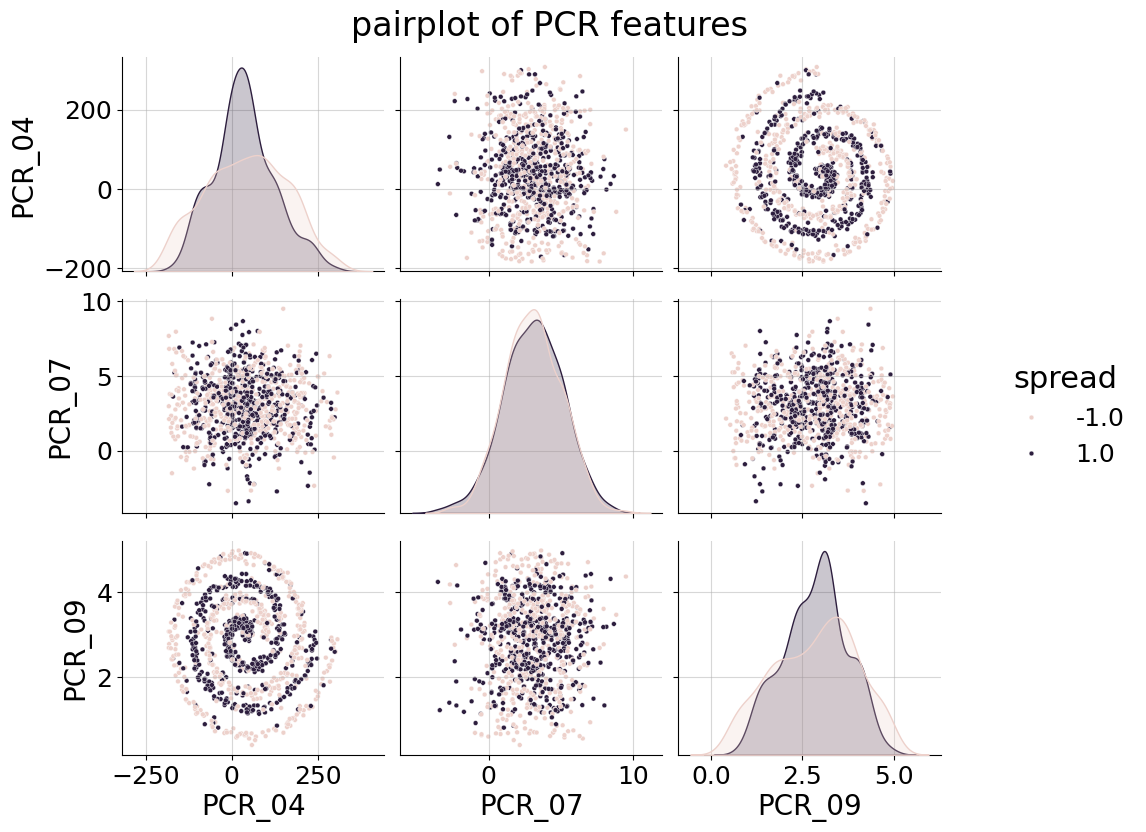

In [12]:
import seaborn as sns
g=sns.pairplot(train, plot_kws={"s": 12},vars=['PCR_04','PCR_07','PCR_09'], hue='spread')
g.fig.suptitle("pairplot of PCR features", y=1.04)

for ax in np.ravel(g.axes):
  ax.grid(alpha=0.5)

g.fig.set_size_inches(12,8)


(Q8)	Answer briefly: Based on the plots you created on (Task B), what pair of features is useful for predicting the spread?
Attach the seaborn.pairplot of only this pair of features to the report. Make sure your plots are readable and clear, and that they have proper titles, grid lines, axis labels, etc. Any missing requirement will lead to a points deduction!


Based on the pairplot, the most visually distinct separation between the spread categories seems to be present in the scatter plot involving PCR_04 and PCR_09. These features exhibit a spiral pattern that distinguishes the two spread categories most clearly.

k-NN implementation
Our first step is to implement a basic k-NN classifier. We will inherit the BaseEstimator class from sklearn for compatibility with scikit-learn API. We will also inherit ClassifierMixin which will automatically add accuracy scoring function to our model.

Task C: Implement k-NN using the code template below (don’t change method signatures):


In [13]:
from sklearn.base import BaseEstimator,ClassifierMixin
from scipy.spatial.distance import cdist


class kNN(BaseEstimator, ClassifierMixin):  # Set number of neighbors
    def __init__(self, n_neighbors: int = 3):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):  # Copies the training data to instance variables
        self.X_train = np.copy(X)
        self.y_train = np.copy(y)
        return self

    def predict(self, X):
        # Compute distances between X and self.X_train
        distances = cdist(X, self.X_train, metric='euclidean')

        # Get indices of the nearest neighbors
        nearest_neighbors_indices = np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]

        # Retrieve the labels of the nearest neighbors
        nearest_neighbors_labels = self.y_train[nearest_neighbors_indices]

        # Majority vote: for each set of nearest neighbors, compute the most frequent label
        predictions = np.sign(np.sum(nearest_neighbors_labels, axis=1))

        return predictions


(Q9)What is the time complexity of the prediction function you wrote, applied on a single test datapoint, in terms of the number of neighbors k, the number of training
datapoints m and the data dimension d? Explain. It is okay to “estimate” the complexity of python library functions. For instance, if you use np.argsort on n elements, then its complexity should be O(n□log log n ). Use your reason and CS knowledge.


distances:
cdist functions computes the Euclidean distance between each pair of the two collections of inputs, X is a single test point,m is the number of data points and the data dimention is d so the complexity is O(m*d)

nearest_neighbors_indices:
the np.argpartition function sorts the array to find the k neareast neighbors (smallest distances from our test point X)
The complexity of this function is O(m) for each row of the distances array

nearest_neighbors_labels:
O(k) because we retrieving the labels of the k nearest neighbors.

Majority vote:
O(k) because we summing the k labels and taking the sign

combining these steps, the overall time complexity is O(m*d) + O(m) + O(k) + O(k) = O(m*d) + O(k) = O(m*d)
that because k>m will be equaly treated like k=m and d is the data dimention.

Task D: Create a temporary DataFrame by taking only the two features you chose on ‎(Q8)  from the training set. Train a 1-NN model (with k=1) on this subset to fit the spread label. Use the provided visualize_clf function to visualize the decision regions of the model (send only the training set to this function, so that only the training examples will be scattered on the plot).
Compute the training accuracy and test accuracy of the model by calling its
score method, e.g., call h.score(Xtrain, Ytrain).

Make sure that all labels in your notebook (the ones in the dataset and the ones your model return) are ±1, and not {0,1} or {True,False}.

(Q10)	 Attach the figure to your report. Specify the model’s training and test accuracies.
(The plot should exhibit a bizarre behavior which we will discuss next.)


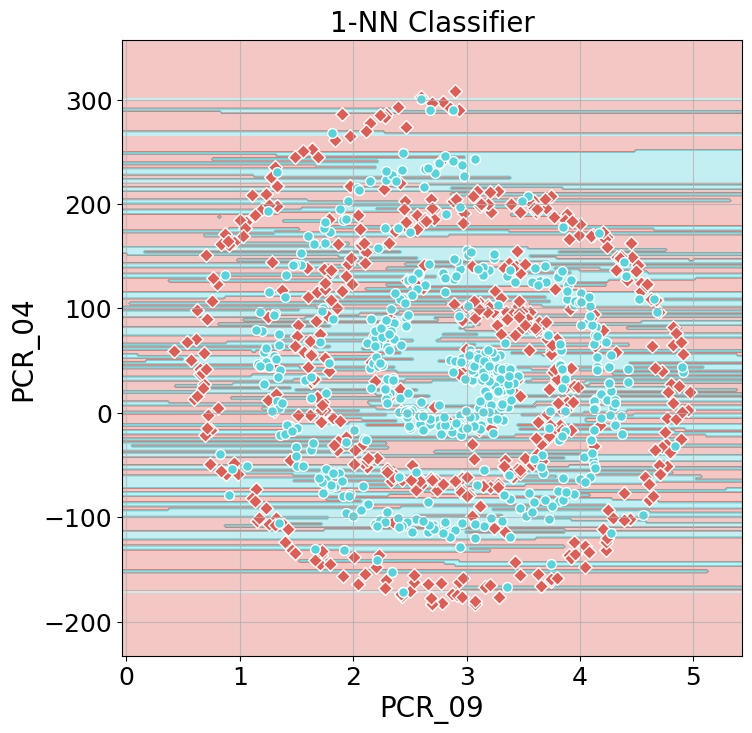

Training Accuracy: 1.0
Test Accuracy: 0.58


In [14]:
# Ensure labels are in ±1 format
train['spread'] = train['spread'].apply(lambda x: 1 if x == 1 else -1)
test['spread'] = test['spread'].apply(lambda x: 1 if x == 1 else -1)

# Create a temporary DataFrame with the selected features
temp_train = train[['PCR_09', 'PCR_04', 'spread']]

# Prepare the data
X_train = temp_train[['PCR_09', 'PCR_04']].values
y_train = temp_train['spread'].values

# Train the 1-NN model
model = kNN(n_neighbors=1)
model.fit(X_train, y_train)

# Visualize the decision regions
visualize_clf(model, X_train, y_train, title="1-NN Classifier", xlabel="PCR_09", ylabel="PCR_04")


# Prepare the test data
X_test = test[['PCR_09', 'PCR_04']].values
y_test = test['spread'].values

# Compute training accuracy
train_accuracy = model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy}")

# Compute test accuracy
test_accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Data Normalization
In machine learning, it is common to normalize the features, as this allows us to develop better models (we will see soon why). We now focus on two normalization techniques: Standardization (Z-score) and min-max scaling (read the explanations in the links). Implementations can be found here and here.

Notice: we often ask questions in the exams regarding reading materials that appear in the assignments.


(Q11)Use min-max scaling (between [-1,1]) to normalize the two features in the temporary DataFrame you created before, and train a new kNN model (k=1) on the normalized dataset.
Compute the new training and test accuracies and draw the decision regions of the model. Attach the results to your report and compare them to those from ‎(Q10) for the same k=1 model on the raw data. Use these results to explain why normalization is important for nearest neighbor models.


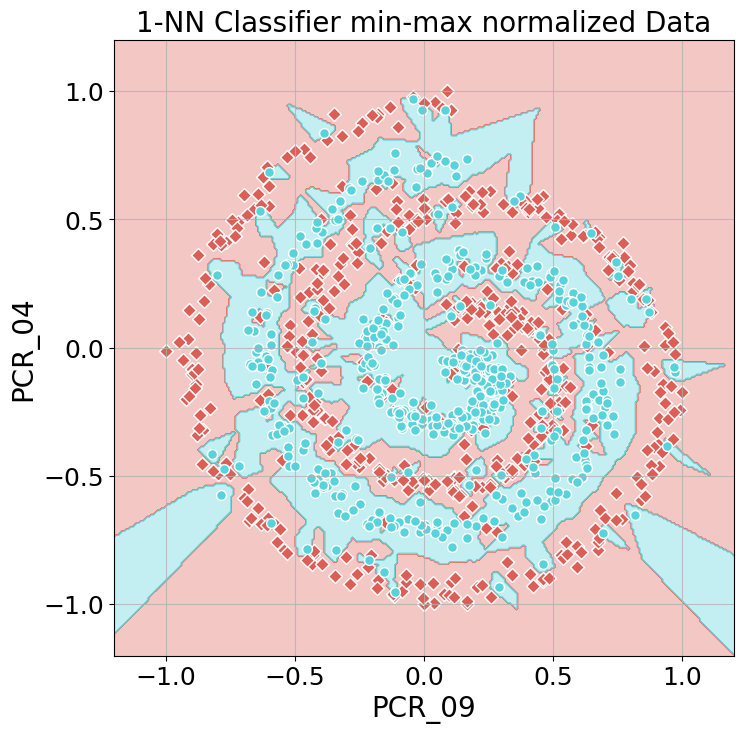

Training Accuracy (Normalized Data): 1.0
Test Accuracy (Normalized Data): 0.692


In [15]:
from sklearn.preprocessing import MinMaxScaler

# Ensure labels are in ±1 format
train['spread'] = train['spread'].apply(lambda x: 1 if x == 1 else -1)
test['spread'] = test['spread'].apply(lambda x: 1 if x == 1 else -1)

# Create a temporary DataFrame with the selected features
temp_train = train[['PCR_09', 'PCR_04', 'spread']]
temp_test = test[['PCR_09', 'PCR_04', 'spread']]

# Prepare the data
X_train = temp_train[['PCR_09', 'PCR_04']].values
y_train = temp_train['spread'].values

X_test = temp_test[['PCR_09', 'PCR_04']].values
y_test = temp_test['spread'].values

# Normalize the features using min-max scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the kNN model on the normalized data
model_scaled = kNN(n_neighbors=1)
model_scaled.fit(X_train_scaled, y_train)

# Visualize the decision regions for the normalized data model
visualize_clf(model_scaled, X_train_scaled, y_train, title="1-NN Classifier min-max normalized Data", xlabel="PCR_09", ylabel="PCR_04")

# Compute training and test accuracy for the normalized data model
train_accuracy_scaled = model_scaled.score(X_train_scaled, y_train)
test_accuracy_scaled = model_scaled.score(X_test_scaled, y_test)
print(f"Training Accuracy (Normalized Data): {train_accuracy_scaled}")
print(f"Test Accuracy (Normalized Data): {test_accuracy_scaled}")

(Q12)Using the normalized dataset, train another kNN model with k= 5. Compute the training and test accuracy and draw the decision regions of this model.
Attach the results to your report and compare them to those from ‎(Q11).
Use these results to briefly explain the effect of k on the decision regions.


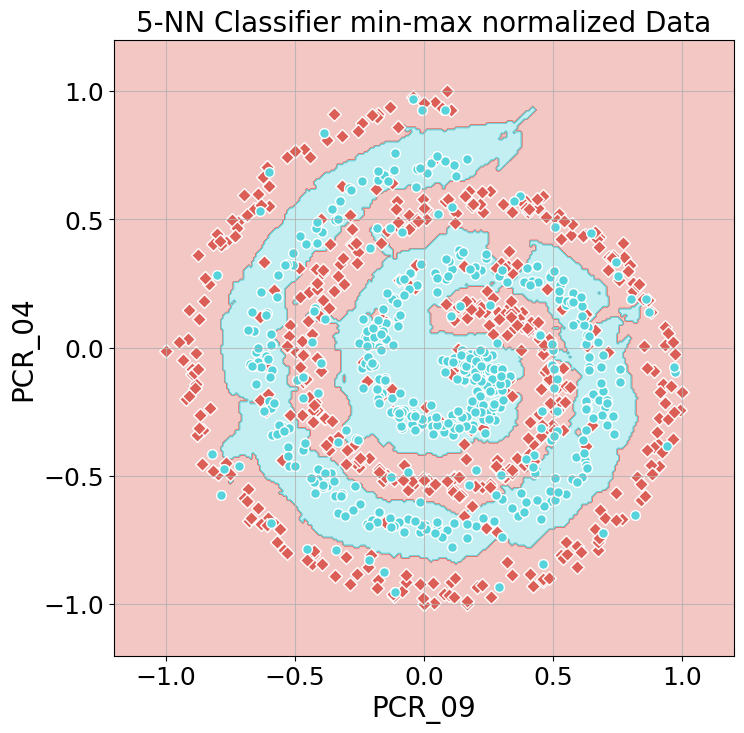

Training Accuracy (Normalized Data): 0.857
Test Accuracy (Normalized Data): 0.796


In [16]:
# Train the kNN model on the normalized data
model_scaled = kNN(n_neighbors=5)
model_scaled.fit(X_train_scaled, y_train)

# Visualize the decision regions for the normalized data model
visualize_clf(model_scaled, X_train_scaled, y_train, title="5-NN Classifier min-max normalized Data", xlabel="PCR_09", ylabel="PCR_04")

# Compute training and test accuracy for the normalized data model
train_accuracy_scaled = model_scaled.score(X_train_scaled, y_train)
test_accuracy_scaled = model_scaled.score(X_test_scaled, y_test)
print(f"Training Accuracy (Normalized Data): {train_accuracy_scaled}")
print(f"Test Accuracy (Normalized Data): {test_accuracy_scaled}")

Normalizing both features using min-max scaling to the range [-1, 1] is prablomatic because of their different distributions. The first feature, which is uniformly distributed between [2, 5], will spread evenly across the new range. But the chi-squared feature, which is highly skewed with most values near 0, will get compressed with most of its values near -1. This makes it harder for algorithms like k-NN to measure distances properly, as the uniform feature will dominate, leading to biased and less effective models.

**Part 4: Data Exploration**

We are now ready to start the preprocessing stage for the rest of the features!

Our medical experts suggest that blood types affect the risk target variable. They propose merging blood types into two groups: {O+, B+} and {O-, A-, A+, B-, AB+, AB-}. That is, instead of having a separate Boolean feature for each blood type, we would have one Boolean feature for these groups.

Task E: According to the suggested groups, create a new Boolean feature called SpecialProperty in your DataFrame, indicating whether the specific data point has a blood type in {O+, B+} or not. Then, remove the original blood_type feature from the DataFrame.

Technical: You can use the following snippet as a starting point to create a Boolean series according to a subset of the values of a feature:
df["blood_type"].isin(["O+", "B+"])


In [17]:
SpecialProperty = train["blood_type"].isin(["O+", "B+"])
train = train.drop("blood_type", axis=1)
train["SpecialProperty"] = SpecialProperty

SpecialProperty = test["blood_type"].isin(["O+", "B+"])
test = test.drop("blood_type", axis = 1)
test["SpecialProperty"] = SpecialProperty

**Univariate Analysis**

You will now carry out most of the univariate analysis in your notebook (or IDE).
You should not add all the plots to the report, only the ones we specifically request.

For every numerical feature (including extracted ones), plot two histograms, one for each target variable (risk and spread), using hue to split by the target variable's value (e.g., high/low spread value). For continuous/ordinal features you should use the kde keyword to draw the estimated distribution curve (see Tutorial 01).


The following code snippet generates a 2-column figure of histograms of the features in the COL_NAME list. You may use this as a template to generate meaningful plots.
Refer to the seaborn documentation to understand more on histplot’s keyword arguments.
[link text](https://)

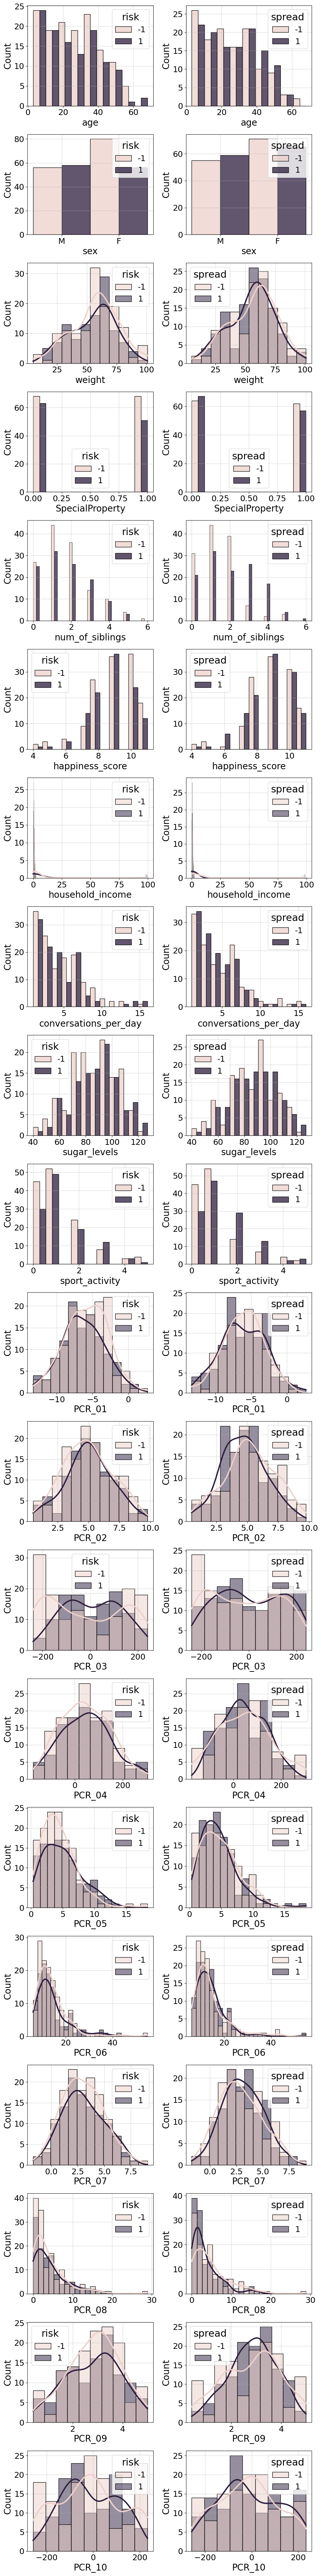

In [18]:
COL_NAME = ['age', 'sex', 'weight', 'SpecialProperty', 'num_of_siblings', 'happiness_score', 'household_income',
            'conversations_per_day', 'sugar_levels', 'sport_activity', 'PCR_01', 'PCR_02', 'PCR_03',
            'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10']
COLS, ROWS = (2, len(COL_NAME))

plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
  column = COL_NAME[row]

  for j, cls in enumerate(["risk", "spread"]):
    plt.subplot(ROWS,COLS, row * COLS + 1 + j)

    isContinuous = "float" in test[column].dtype.name
    sns.histplot(data=test, x=column, hue=cls, line_kws={"linewidth": 3},
                 kde=isContinuous, multiple="layer" if isContinuous else "dodge")
    plt.grid(alpha=0.5)

plt.tight_layout()

To clarify: in your jupyter notebook you should generate 2 histograms for every feature.
Each histogram corresponds to one target feature (risk, spread), where the different labels are counted separately and colored differently. Continuous variable histograms should also have estimated distribution curves (using the kde argument).



(Q14)	According to the univariate analysis, name one feature that seems informative for predicting the spread target variable (other than the 2 features from Q8).
Attach the appropriate univariate plot and briefly explain (2-3 sentences) why this plot makes you think that feature is informative.


According to the univariate analysis, a feature that seems informative for predicting the spread target variable is 'num_of_siblings'.
The plot suggests it is an informative feature because of the following:
For each value, there is a clear majority of subjects that are positive or negative to the spread variable.
Therefore, it might be a good feature to consider as we try to classify which new subjects might be positive to the spread variable.

(Q15)	According to the univariate analysis, name one feature that seems informative for predicting the risk target variable (other than the blood groups).
Attach the appropriate univariate plot and briefly explain (2-3 sentences) why this plot makes you think that feature is informative.


According to the univariate analysis, the 'PCR_3' feature seems informative for predicting the risk target variable.
Similary to the reason we chose the 'num_of_siblings' feature as an informative feature to predict the spread target variable, the 'PCR_3' feature shows that for most accepted values, there is a majority of samples that are positive or negative to the risk variable.
Furthermore, the distribution estimated by the histogram suggests that negative and positive samples for the risk variable have clearly distinguished distribution with respect to the 'PCR_3' feature.

**Bivariate Analysis**

We will now perform some bivariate analysis.
The following snippet performs basic bivariate analysis for the PCR features, conditioned on the risk variable. This snippet is a good reference for the next question.


In [19]:
#sns.pairplot(df[df.filter(like='PCR').columns.tolist() + ["risk"]], 		  plot_kws={"s": 3}, hue="risk")

Our medical experts believe that it is possible to predict the risk using a pair of PCR features from the set: {PCR_01, PCR_03 , PCR_05 , PCR_10}, but only after splitting the data according to blood groups.

(Q16)	Split the (training) data based on the binary SpecialProperty feature created in (Task E). For each split, perform a bivariate analysis for the PCR features in the set, in relation to the risk. This means you should produce two “matrices” of plots, one for each blood group. Each matrix should contain 4x4 subplots, representing all possible pairs of PCR features in the set. Do not include these plots in your report.
According to those plots, choose a pair of PCR features that could be helpful
for predicting the risk (with the partition according to the SpecialProperty).
What PCR features did you choose? And why?


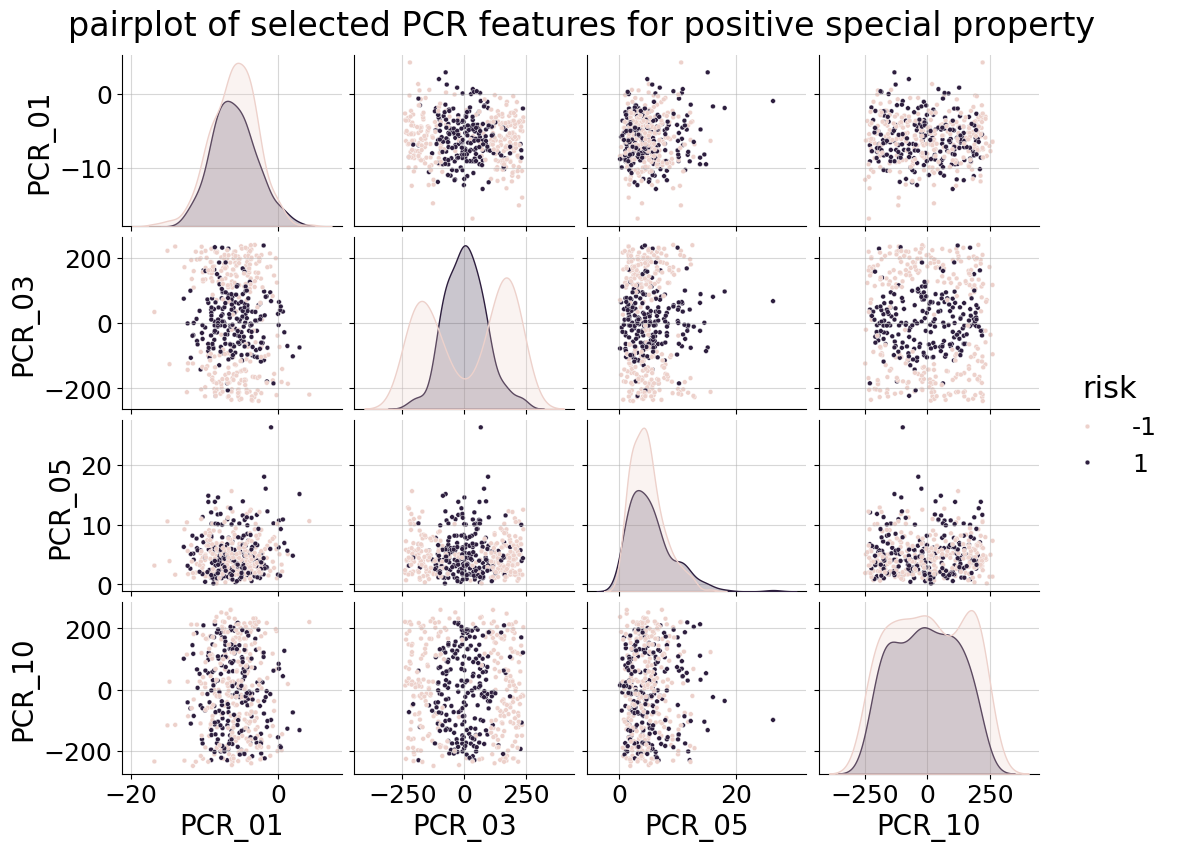

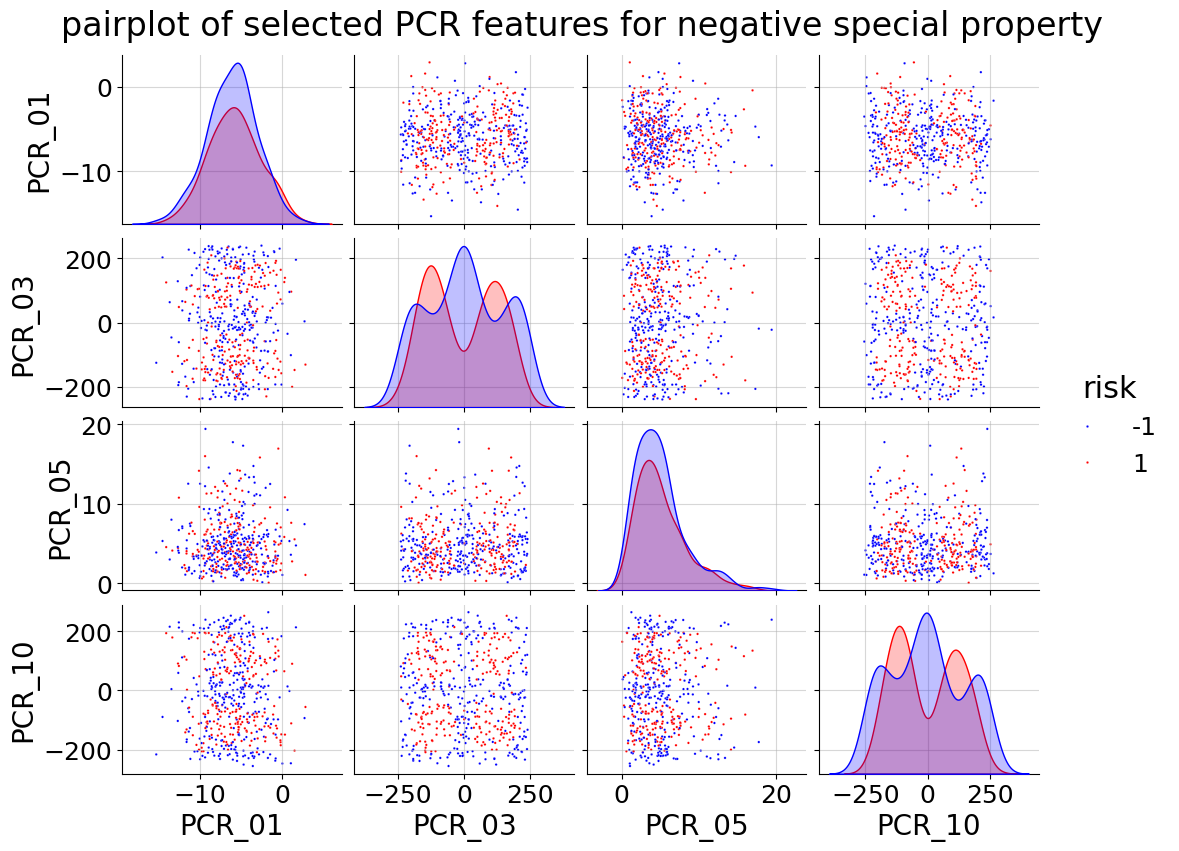

In [20]:
PosSpecialProperty = train[train['SpecialProperty'] == True]
NegSpecialProperty = train[train['SpecialProperty'] == False]

#g=sns.pairplot(PosSpecialProperty[["PCR_01", "PCR_03", "PCR_05", "PCR_10", "risk"]], plot_kws={"s": 3}, hue="risk", palette=['blue', 'red'])
g=sns.pairplot(PosSpecialProperty, plot_kws={"s": 12},vars=['PCR_01','PCR_03','PCR_05','PCR_10'], hue='risk')
g.fig.suptitle("pairplot of selected PCR features for positive special property", y=1.04)

for ax in np.ravel(g.axes):
  ax.grid(alpha=0.5)

g.fig.set_size_inches(12,8)

g=sns.pairplot(NegSpecialProperty[["PCR_01", "PCR_03", "PCR_05", "PCR_10", "risk"]], plot_kws={"s": 3}, hue="risk", palette=['blue', 'red'])
g.fig.suptitle("pairplot of selected PCR features for negative special property", y=1.04)

for ax in np.ravel(g.axes):
  ax.grid(alpha=0.5)

g.fig.set_size_inches(12,8)




We chose the pair ('PCR_03', 'PCR_10').

Firstly, we noticed that there are 3 candidate pairs for good separation for the positive to special property group.

Crossing it with the respective plots of the negative for special property group, it seemed like all of it didn't follow the exact same patterns, but the data was fairly separable for all of it.

Finally, we decided to proceed with that pair, as it seemed like it offers better separation for the negative group than the others.


(Q17)	For the pair of PCR features you chose in (Q16), create three jointplots (see Tutorial 01), all conditioned on the risk variable. The first jointplot should include only the data in the first blood group you created in (Task E), {O+, B+}. The second jointplot should include only the data in the other blood group. The third jointplot should be for the full data, without partitioning to blood groups.
Attach the 3 resulting plots to your report. Remember to have grids, titles, and axis-labels.

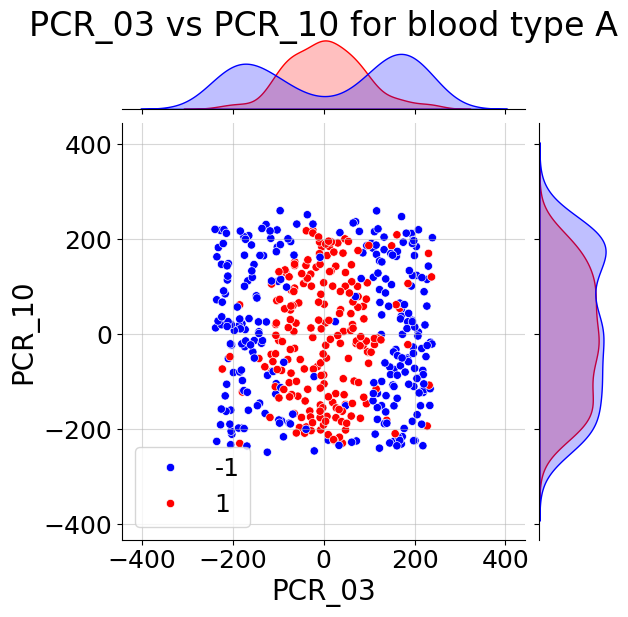

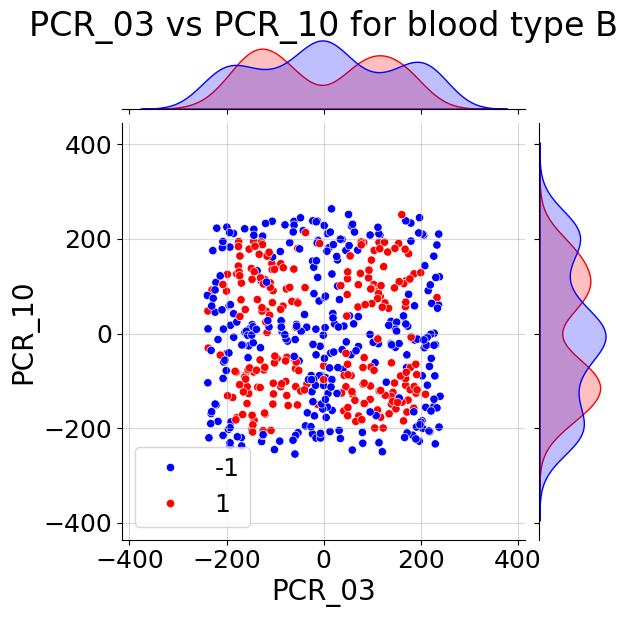

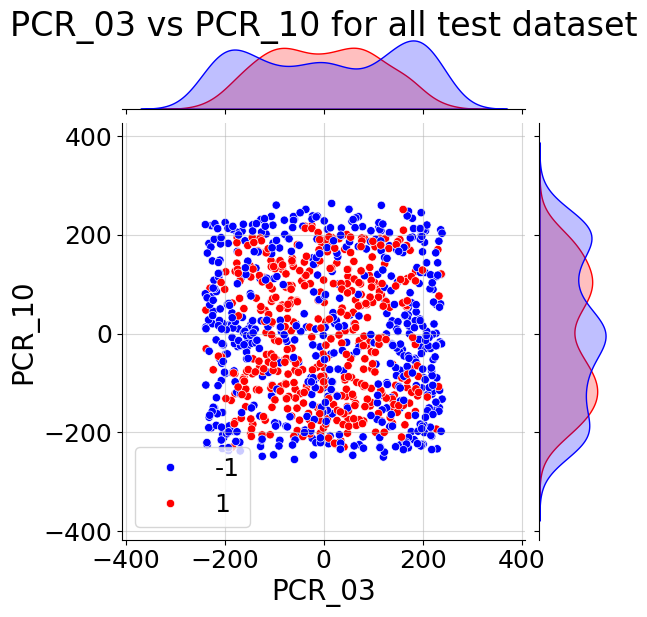

In [21]:
x_var = 'PCR_03'
y_var = 'PCR_10'
hue_var = 'risk'

g = sns.jointplot(data=PosSpecialProperty, x=x_var, y=y_var, hue=hue_var, kind='scatter', palette=['blue', 'red'])
g.fig.suptitle("PCR_03 vs PCR_10 for blood type A", y=1.02)
g.ax_joint.legend(loc='lower left')
_ = g.ax_joint.grid(alpha=0.5)

g = sns.jointplot(data=NegSpecialProperty, x='PCR_03', y='PCR_10', hue='risk', kind='scatter', palette=['blue', 'red'])
g.fig.suptitle("PCR_03 vs PCR_10 for blood type B", y=1.02)
g.ax_joint.legend(loc='lower left')
_ = g.ax_joint.grid(alpha=0.5)

g = sns.jointplot(data = train, x=x_var, y=y_var, hue=hue_var, kind='scatter', palette=['blue', 'red'])
g.fig.suptitle("PCR_03 vs PCR_10 for all test dataset", y=1.02)
g.ax_joint.legend(loc='lower left')
_ = g.ax_joint.grid(alpha=0.5)


**The risk target feature**

The following snippet demonstrates a call to the provided plot3d function:


In [22]:
#plot3d(df, "PCR_01", "SpecialProperty", "PCR_02", title="TODO", hue="risk", s=5)

(Q18)	Use the provided function plot3d to plot the pair of PCR features you chose (axes X and Z) and the SpecialProperty feature (axis Y), colored by the risk label. Make sure that the plot is clear & readable and that it has a proper title. Attach the plot to your report.

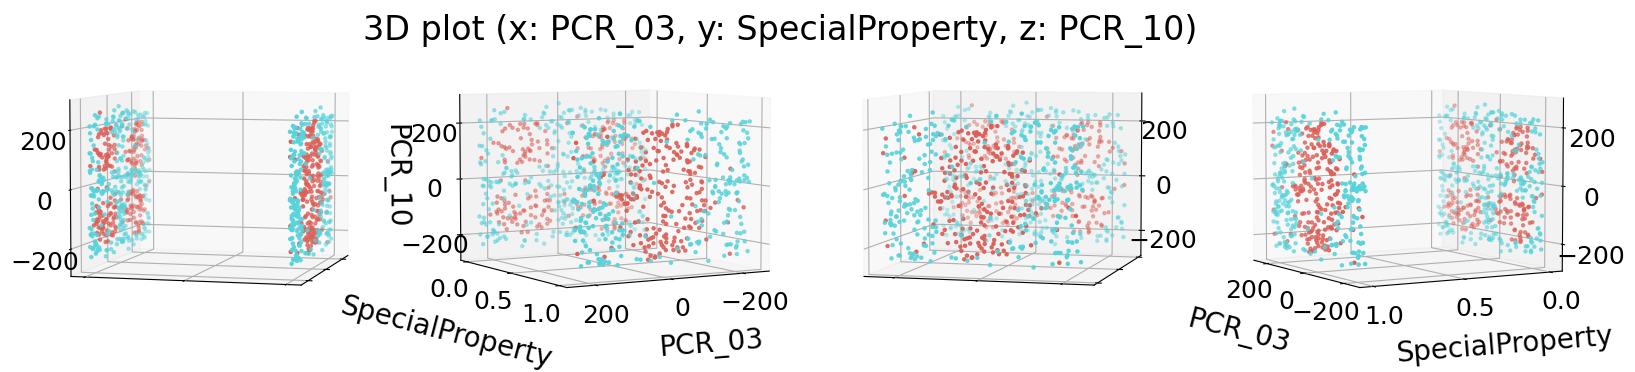

In [23]:
def plot3d(df, colX, colY, colZ, title, hue=None, s=1):
  %matplotlib inline

  fig = plt.figure(figsize=(20, 4))
  axes = [fig.add_subplot(1, 4, 1, projection='3d'),
          fig.add_subplot(1, 4, 2, projection='3d'),
          fig.add_subplot(1, 4, 3, projection='3d'),
          fig.add_subplot(1, 4, 4, projection='3d')]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if hue is None:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=s)
    else:
      idx = df[hue] == True
      df1 = df[idx]
      df2 = df[~idx]

      ax.scatter3D(df1[colX], df1[colY], df1[colZ], color=palette[0], s=s)
      ax.scatter3D(df2[colX], df2[colY], df2[colZ], color=palette[1], s=s)

    if i == 3 or i == 1:
      ax.set_xlabel(colX, labelpad=20)
      ax.set_ylabel(colY, labelpad=20)
    else:
      ax.xaxis.set_ticklabels([])
      ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i+15)

  axes[1].set_zlabel("\n" + colZ, labelpad=1)

  plt.suptitle(title)
  plt.subplots_adjust(wspace=0.1, top=0.99)
  plt.show()

plot3d(train, "PCR_03", "SpecialProperty", "PCR_10", title="3D plot (x: PCR_03, y: SpecialProperty, z: PCR_10)", hue="risk", s=5)

In the following questions, we will analyze how well various models fit the training data. We will use three features: the two PCR features and the SpecialProperty feature, aiming to fit the risk. Explain your answers in detail (2-5 sentences per model). No code execution is required. These questions focus only on whether a model can fit the training data, not on generalization (i.e., test data) or optimization (finding the model).

(Q19)	How well will a decision tree of max-depth=3 be able to fit the training data?
Explain briefly.


We don't think a decision tree of max depth 3 would be able to fit the training data well.

According to the plot, such a decision tree would not be able to follow the separability patterns of the data with great resolution, therefore it wouldn't fit the training data well.

If we were to decide manually on how to split the data, we could possibly have a decent fit for the positive to SpecialProperty group, but not for the negative to SpecialProperty group.


(Q20)	How well will a decision tree of max-depth=30 be able to fit the training data?
Explain briefly.


A decision tree of max_depth up to 30 will fit the training data very well (perhaps perfectly).
That is due to the fact that the data is separable with respect to the features we are looking at.
Therefore a decision tree of depth 30 will allow us to take advantage of that separability to classify the training data with great resolution.

(Q21)	How well will a 1-NN model be able to fit the training data? Note that in this question, a point in the training set is not considered its own neighbor (i.e., when making a prediction for a training data point, the model won't use the same point for prediction, but only the nearest point in the remaining training set).

Hint: consider the scale of the features in your answer.


We don't think a 1-NN model will be able to fit the training data well.
Considering the scale of the special property feature against the scale of the PCR features, it is likely that the nearest sample point would be related to the other blood type group.

That will effectively deny the partitioning of the training set according to the special property. Since we had already established that the negative for SpecialProperty and positive for SpecialProperty groups do not follow perfect match in its patterns, related to the target feature, this could possibly lead to lots of misclassifications.


**Part 5: More Data Normalization**

We will now complete the normalization process for all the PCR features.

Task F: Use the univariate analysis above to choose an appropriate normalization method (see Part 2) for every PCR feature in your DataFrame. Accordingly, apply sklearn’s StandardScaler and MinMaxScaler to those features.
In ‎(Q23) you are asked to specify the normalization method you chose for each feature.
Hint: Think about ‎(Q13) when deciding which scaler to use for each feature.

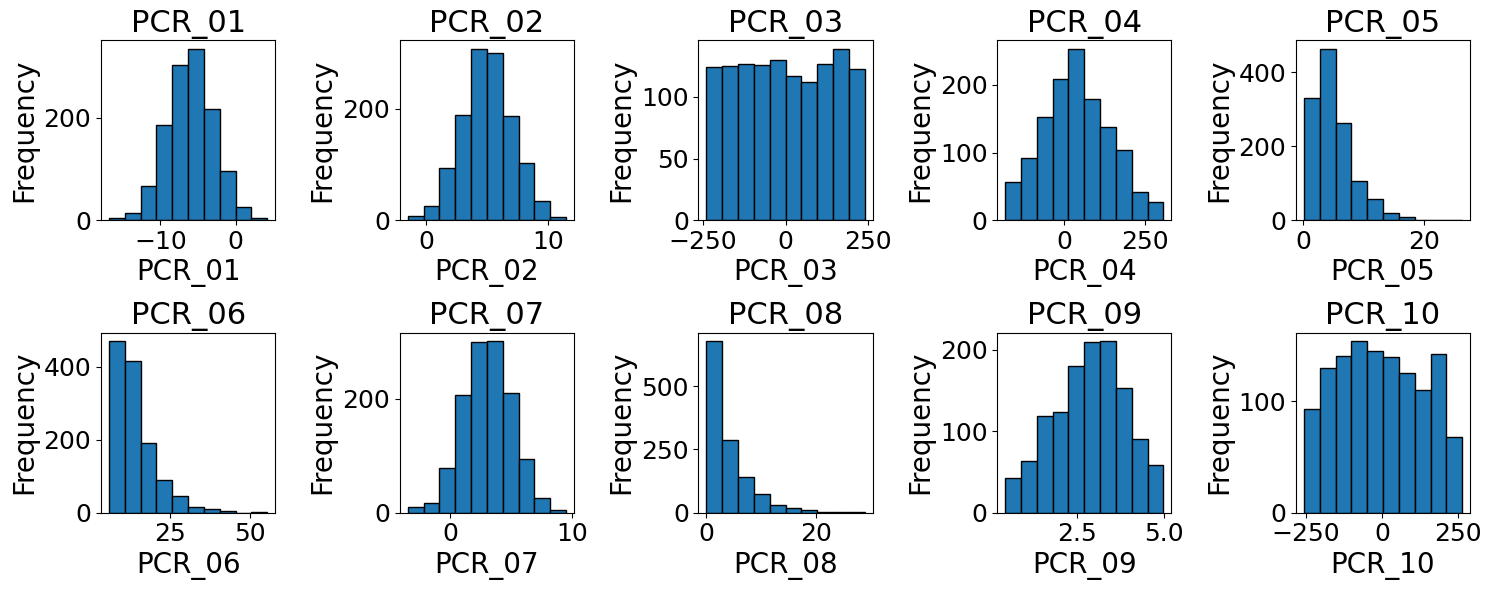

In [24]:
plt.figure(figsize=(15, 6))

features = ['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05',
            'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10']

for i, feature in enumerate(features):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    data[feature].plot(kind='hist', bins=10, edgecolor='black')
    plt.title(feature)
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

standard_features = ['PCR_01','PCR_02','PCR_04','PCR_07','PCR_09']
minmax_features = ['PCR_03', 'PCR_05', 'PCR_06', 'PCR_08', 'PCR_10']

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

#fit the scalers according to train dataset
standard_scaler.fit(train[standard_features])
minmax_scaler.fit(train[minmax_features])

"""
# Scale standard features
train[standard_features] = standard_scaler.fit_transform(train[standard_features])
test[standard_features] = standard_scaler.transform(train[standard_features])

# Scale minmax features
train[minmax_features] = minmax_scaler.fit_transform(train[minmax_features])
test[minmax_features] = minmax_scaler.transform(train[minmax_features])
"""

#transforms the train and test
train[standard_features] = standard_scaler.transform(train[standard_features])
train[minmax_features] = minmax_scaler.transform(train[minmax_features])

test[standard_features] = standard_scaler.transform(test[standard_features])
test[minmax_features] = minmax_scaler.transform(test[minmax_features])




(Q22)	What will be the effects of data normalization on your answers in ‎(Q19), ‎(Q20), ‎(Q21)?

Q19:
Normalization won't impact the performance significantly because the decision tree has a depth of only 3, which is limited for this data. The tree's ability to fit the training data is restricted by its shallow depth rather than the scale of the features.

Q20:
Normalization could lead to a more balanced decision tree and potentially improve fitting. By ensuring all features contribute equally, normalization can help the decision tree make more balanced splits, improving the model's overall performance.

Q21:
Normalization will significantly improve the performance of the 1-NN model. Before normalization, the varying scales of features can cause issues with distance calculations, leading to incorrect nearest neighbor identification. By bringing all features to the same scale, normalization ensures each feature contributes equally to the distance calculations, leading to more accurate nearest neighbor identification and better fitting of the training data.



**Part 6: Data Preparation Pipeline**

We have finished exploring and preparing our data. Throughout this assignment, you transformed features, normalized the data, and so on.

(Q23)	Write a table summarizing the data preparation process you created.
The columns of the table must be:
a.	Feature name: the name of the feature as written in the dataset.
Names of new features should be meaningful!
b.	Keep: “V” if the feature is kept, “X” otherwise (e.g., blood_type is removed).
c.	New: “V” if the feature was handcrafted using other feature(s), “X” otherwise.
d.	Normalization method, if used.

Table in the report


Now, let’s create an automatic data preparation pipeline for preparing incoming data for prediction. This pipeline should be based only on the training set. For example, if you normalized a feature using the standard scaler, you should calculate the mean and std from the training data, and apply this normalization to the new data.

Task H: Write a module  called prepare.py containing a function with the following signature:
def prepare_data(training_data, new_data)
The new_data parameter is the DataFrame to be prepared and training_data is the training set DataFrame used during data exploration. Your function should perform as described in ‎(Q23). The output is a copy of new_data (the original parameter should remain unchanged), after it has been preprocessed according to the provided training_data.
You are required to submit prepare.py.


In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def prepare_data(training_data, new_data):
    #creates a copy of new_data
    copy_df = new_data.copy()

    #fills NA data for columns with missing entries
    copy_df["household_income"] = copy_df.household_income.fillna(training_data.household_income.median())

    #makes special property according to blood_type feature
    SpecialProperty = copy_df["blood_type"].isin(["O+", "B+"])
    copy_df = copy_df.drop("blood_type", axis=1)
    copy_df["SpecialProperty"] = SpecialProperty

    #applying normalization for PCR features
    MinMaxScalarNormalization = ["PCR_03", "PCR_05", "PCR_06", "PCR_08", "PCR_10"]
    StandardScalarNormalization = ["PCR_01", "PCR_02", "PCR_04", "PCR_07", "PCR_09"]

    standard_scalar = StandardScaler()
    minmax_scalar = MinMaxScaler()

    standard_scalar.fit(training_data[StandardScalarNormalization])
    minmax_scalar.fit(training_data[MinMaxScalarNormalization])

    copy_df[MinMaxScalarNormalization] = minmax_scalar.transform(copy_df[MinMaxScalarNormalization])
    copy_df[StandardScalarNormalization] = standard_scalar.transform(copy_df[StandardScalarNormalization])

    #data is prepared
    return copy_df


Apply the function to both the train and test sets like so:

In [27]:
train_pre_processed = pd.read_csv("train.csv")
test_pre_processed = pd.read_csv("test.csv")

# Prepare training set according to itself
train_df_prepared = prepare_data(train_pre_processed, train_pre_processed)

# Prepare test set according to the raw training set
test_df_prepared = prepare_data(train_pre_processed, test_pre_processed)


Save your two preprocessed DataFrames as CSV files and keep them for the next assignment. Do not submit any CSV files!

Important: Return to the instructions at the beginning of the document and make sure that you submit all the required files!
